In [148]:
from utils import *

In [149]:
generate_inventory(verbose=True)

Total Monies: 873.12
Saving inventory data with (117, 6) shape


In [391]:
get_character_needs(['Melue', 'Zegna'])

{'Melue': {'Free Action Potion': -1}, 'Zegna': {}}

In [151]:
generate_auction_history(verbose=True)

11432 auction events
8622 auction events of interest


In [395]:
add_item_prices()

In [696]:
ingredient_raw

,gross_profit,auction_success,made_from,ingredient_value
Arcane Elixir,2705,0.987179,"{'Blindweed': 1, 'Crystal Vial': 1, 'Goldthorn...",2670.32
Elixir of Fortitude,4694,0.920455,"{'Goldthorn': 1, 'Leaded Vial': 1, 'Wild Steel...",4320.61
Elixir of Giants,2809,0.954357,"{'Crystal Vial': 1, 'Gromsblood': 1, 'Sungrass...",2680.79
Elixir of Greater Agility,1130,0.966805,"{'Crystal Vial': 1, 'Goldthorn': 1, 'Sungrass'...",1092.49
Elixir of Greater Intellect,2752,0.727273,"{'Blindweed': 1, 'Khadgar's Whiskers': 1, 'Lea...",2001.45
Elixir of Superior Defense,2112,0.659686,"{'Crystal Vial': 1, 'Leaded Vial': 2, 'Stonesc...",1393.26
Elixir of the Mongoose,6395,0.991701,"{'Crystal Vial': 1, 'Mountain Silversage': 2, ...",6341.93
Fire Protection Potion,4580,0.958506,"{'Empty Vial': 1, 'Firefin Snapper': 2, 'Leade...",4389.96
Greater Stoneshield Potion,928,0.766667,"{'Crystal Vial': 1, 'Leaded Vial': 3, 'Stonesc...",711.467
Invisibility Potion,6892,0.623377,"{'Crystal Vial': 1, 'Ghost Mushroom': 1, 'Sung...",4296.31


In [700]:
xs.sum()

Blindweed              4
Goldthorn              3
Wild Steelbloom        1
Gromsblood             4
Sungrass               4
Khadgar's Whiskers     1
Stonescale Eel         5
Mountain Silversage    2
Plaguebloom            2
Firefin Snapper        2
Small Flame Sac        1
Thorium Ore            1
Ghost Mushroom         2
dtype: int64

In [701]:
beta_proportion

Blindweed              0.063367
Goldthorn              0.060831
Wild Steelbloom        0.098392
Gromsblood             0.081727
Sungrass               0.050804
Khadgar's Whiskers     0.050136
Stonescale Eel         0.032589
Mountain Silversage    0.142603
Plaguebloom            0.143832
Firefin Snapper        0.129959
Small Flame Sac        0.066508
Thorium Ore            0.010054
Ghost Mushroom         0.069199
dtype: float64

In [599]:
verbose = True

with open('intermediate/items_enriched.yaml', 'r') as f:
    user_items = yaml.load(f, Loader=yaml.FullLoader)

ingredient_raw = pd.DataFrame.from_dict(user_items).T[['gross_profit', 'auction_success', 'made_from']].dropna()

ingredient_raw['ingredient_value'] = ingredient_raw['gross_profit'] * ingredient_raw['auction_success']

ingredient_df = pd.DataFrame()
for item, recipe in ingredient_raw['made_from'].items():
    for ingredient, count in recipe.items():
        ingredient_df.loc[item, ingredient] = count
        
xs = ingredient_df.drop(['Crystal Vial', 'Leaded Vial', 'Empty Vial'], axis=1).fillna(0).astype(int)
ys = ingredient_raw['ingredient_value']

In [691]:
def update_beta(pred_beta, y, x, learning_rate=0.02):
    actual_value = y * (x / x.sum())
    actual_value = actual_value[actual_value>0]

    new_beta = pred_beta.copy()
    new_beta.update(actual_value)

    # Introduce some truthiness to the betas
    pred_beta += ((new_beta - pred_beta) * learning_rate)
    return pred_beta

In [692]:
import numpy as np

In [693]:
random_start = ((np.random.rand(len(xs.columns)) - 0.5) + 1) * ys.mean()

In [694]:
pred_beta = pd.Series(random_start, index=xs.columns)

Blindweed              0.063367
Goldthorn              0.060831
Wild Steelbloom        0.098392
Gromsblood             0.081727
Sungrass               0.050804
Khadgar's Whiskers     0.050136
Stonescale Eel         0.032589
Mountain Silversage    0.142603
Plaguebloom            0.143832
Firefin Snapper        0.129959
Small Flame Sac        0.066508
Thorium Ore            0.010054
Ghost Mushroom         0.069199
dtype: float64

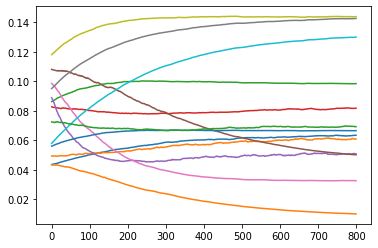

In [695]:
all_betas = pd.DataFrame(columns=pred_beta.index)

for i in range(800):
    for item, y in ys.sample(10).items():
        x = xs.loc[item]
        pred_beta = update_beta(pred_beta, y, x, learning_rate=0.005)
        
        if verbose:
            beta_proportion = ((pred_beta / pred_beta.sum()))
            all_betas.loc[i] = beta_proportion
if verbose:
    all_betas.plot(legend=False)
            
beta_proportion = ((pred_beta / pred_beta.sum()))            
beta_proportion         

In [703]:
beta_proportion.sort_values()

Thorium Ore            0.010054
Stonescale Eel         0.032589
Khadgar's Whiskers     0.050136
Sungrass               0.050804
Goldthorn              0.060831
Blindweed              0.063367
Small Flame Sac        0.066508
Ghost Mushroom         0.069199
Gromsblood             0.081727
Wild Steelbloom        0.098392
Firefin Snapper        0.129959
Mountain Silversage    0.142603
Plaguebloom            0.143832
dtype: float64

In [702]:
# Need a POPULARITY metric, something that signifies how many of the last x auctions have been item